In [1]:
import matplotlib.pyplot as plt
import torch

from sbi.diagnostics.misspecification import calculate_p_misspecification

/Users/corneliusschroeder/anaconda3/envs/sbi_dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:
# generate some dummy data for testing
def generate_dummy_data(n_samples: int, n_features=4, offset=0):
    x = torch.randn(n_samples, n_features) + offset
    return x


x = generate_dummy_data(10_000)
x_obs = generate_dummy_data(1, offset=2)

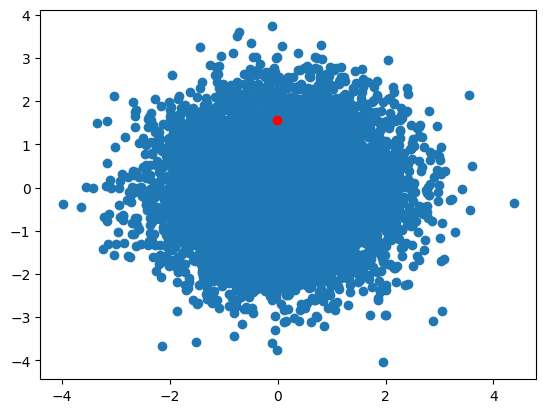

In [51]:
plt.plot(x[:, 0], x[:, 1], "o")
plt.plot(x_obs[:, 0], x_obs[:, 1], "o", color="red")

In [ ]:
p_val, mmds_baseline, mmd = calculate_p_misspecification(
    x_obs, x, n_shuffle=1000, max_samples=1000, mode="biased"
)
print(p_val)

0.03420000000000001


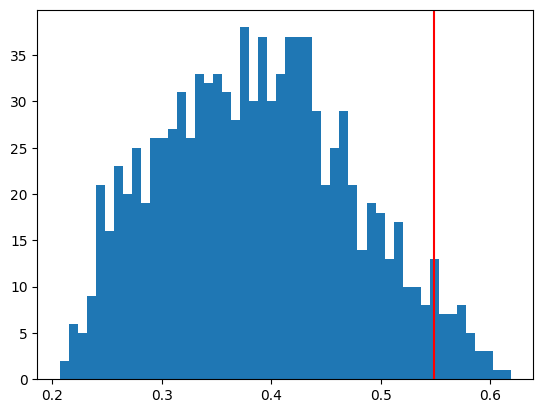

In [55]:
plt.hist(mmds_baseline.numpy(), bins=50)
plt.axvline(mmd, color="red")
plt.show()